In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import heapq

In [ ]:
tickers = ['AAPL', 'NVDA', 'MSFT', 'GOOG', 'GOOGL', 'AMZN', 'META', 'AVGO', 'LLY',
 'TSLA', 'WMT', 'JPM', 'UNH', 'XOM', 'V', 'ORCL', 'MA', 'HD', 'PG', 'COST', 'JNJ',
 'ABBV', 'NFLX', 'BAC', 'KO', 'CRM', 'MRK', 'CVX', 'AMD', 'TMUS', 'PEP', 'TMO',
 'ACN', 'LIN', 'ADBE', 'MCD', 'IBM', 'CSCO', 'GE', 'ABT', 'WFC', 'NOW', 'DHR',
 'CAT', 'AXP', 'QCOM', 'PM', 'TXN', 'VZ', 'MS', 'INTU', 'AMGN', 'ISRG', 'DIS',
 'AMAT', 'GS', 'NEE', 'PFE', 'UBER', 'RTX', 'SPGI', 'CMCSA', 'LOW', 'T', 'PGR',
 'UNP', 'BKNG', 'LMT', 'BLK', 'HON', 'SYK', 'ETN', 'COP', 'ANET', 'TJX', 'BSX',
 'VRTX', 'NKE', 'SCHW', 'C', 'PANW', 'KKR', 'MU', 'ADP', 'ADI', 'ELV', 'BX', 'MDT',
 'UPS', 'DE', 'MMC', 'CB', 'PLD', 'FI', 'REGN', 'KLAC', 'SBUX', 'LRCX', 'BMY']

n = len(tickers)
original_data = []
for ticker in tickers:
  data = yf.download(ticker, start="2022-01-01", end="2024-03-30")
  original_data.append(data)

/tmp/ipython-input-1271094889.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2022-01-01", end="2024-03-30")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1271094889.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2022-01-01", end="2024-03-30")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1271094889.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2022-01-01", end="2024-03-30")
[*********************100%***********************]  1 of 1 completed
/tmp/ipython-input-1271094889.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2022-01-01", end="2024-03-30")
[*********************100%***********************]  1 of 1 comple

The code (shown in below cell) takes raw stock price data and converts it into a ramework optimized for contrarian reversal trading.

For each stock, it handles data formatting then adds in indicator systems, including:
- Trend indicators (with 60-day volatility)
- Support/resistance levels (rolling minimums/maximums over 20/60/120-day periods to identify when prices are near historical lows)
- Momentum indicators (MACD with signal line, histogram, and 5-day slope to detect momentum shifts)
- Mean reversion signals (14-day RSI for oversold conditions)
- Drawdown measurements (distance from recent highs to quantify how a stock has fallen)
- Volume analysis (20-day volume moving average)

In [ ]:
print("Calculating technical indicators...")

new_data = []
for i in range(n):
    df = original_data[i].copy()

    # Handle potential MultiIndex columns from yfinance
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.droplevel(1)

    # Use the correct column names (handle both 'Adj Close' and 'Close')
    close_col = 'Adj Close' if 'Adj Close' in df.columns else 'Close'
    high_col = 'High' if 'High' in df.columns else df.columns[1]
    low_col = 'Low' if 'Low' in df.columns else df.columns[2]
    volume_col = 'Volume' if 'Volume' in df.columns else df.columns[-1]

    # Original volatility measure
    window = 60
    df['SMA'] = df[close_col].rolling(window=window).mean()
    df['STD'] = df[close_col].rolling(window=window).std() / df[close_col].rolling(window=window).mean()

    # Moving averages for trend detection
    df['SMA_5'] = df[close_col].rolling(window=5).mean()
    df['SMA_10'] = df[close_col].rolling(window=10).mean()
    df['SMA_20'] = df[close_col].rolling(window=20).mean()
    df['SMA_50'] = df[close_col].rolling(window=50).mean()

    # CONTRARIAN/REVERSAL INDICATORS

    # 1. Historical support levels (rolling mins over different periods)
    df['Support_20'] = df[low_col].rolling(window=20).min()
    df['Support_60'] = df[low_col].rolling(window=60).min()
    df['Support_120'] = df[low_col].rolling(window=120).min()

    # 2. Distance from support (lower is more contrarian)
    df['Dist_Support_20'] = (df[close_col] - df['Support_20']) / df['Support_20']
    df['Dist_Support_60'] = (df[close_col] - df['Support_60']) / df['Support_60']
    df['Dist_Support_120'] = (df[close_col] - df['Support_120']) / df['Support_120']

    # 3. MACD for momentum detection
    exp1 = df[close_col].ewm(span=12).mean()
    exp2 = df[close_col].ewm(span=26).mean()
    df['MACD'] = exp1 - exp2
    df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
    df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

    # 4. MACD slope (rising momentum indicator)
    df['MACD_Slope'] = df['MACD'].diff(5)  # 5-day slope

    # 5. RSI for oversold conditions
    delta = df[close_col].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))

    # 6. Price relative to recent highs (more contrarian when lower)
    df['High_60'] = df[high_col].rolling(window=60).max()
    df['Drawdown'] = (df[close_col] - df['High_60']) / df['High_60']

    # 7. Volume surge indicator (often precedes reversals)
    if volume_col in df.columns and not df[volume_col].isna().all():
        df['Volume_SMA_20'] = df[volume_col].rolling(window=20).mean()
        df['Volume_Ratio'] = df[volume_col] / df['Volume_SMA_20']
    else:
        # If no volume data, set neutral values
        df['Volume_SMA_20'] = 1
        df['Volume_Ratio'] = 1

    # Store the close column name for later use
    df['_close_col'] = close_col

    new_data.append(df)

print("Technical indicators calculated!")

Calculating technical indicators...
Technical indicators calculated!


Now, we define core parameters to see how the contrarian strategy works. We can arbitrarily set the starting capital at \$500 and set the positions to 3 to cap the number of stocks simultaneously held (with the automatic size of \$100 spent per stock).
- Chose 3 positions because then we look at the top 3 signals (not 4th or 5th best)

Each stock needs a signal score of at least 4 (calculated through above indicators) to be traded, and rolling window calculations are implemented so that we can start trading after 120 days.
- Chose 60 day window to avoid false signals + noise

In [ ]:
# Strategy parameters
INITIAL_MONEY = 500
N_POSITIONS = 3
POSITION_SIZE = 100
MIN_SIGNAL_THRESHOLD = 4  # Minimum signal score to trade
LOOKBACK_START = 60  # Start trading after this many days

print("Strategy Parameters:")
print(f"Initial Capital: ${INITIAL_MONEY}")
print(f"Max Positions: {N_POSITIONS}")
print(f"Position Size: ${POSITION_SIZE}")
print(f"Min Signal Threshold: {MIN_SIGNAL_THRESHOLD}")


Strategy Parameters:
Initial Capital: $500
Max Positions: 3
Position Size: $100
Min Signal Threshold: 4


The algorithm (in the cell below) implements the core thought process for contrarian reversal trading. Every day, it identifies and trades market reversals. The algorithm iterates through each trading day from day 60 and evaluates all stocks using the multi-factor scoring system (from above). Stocks receive points for things like:
- being within 5% of 60-day support
- having rising momentum (identified from positive MACD slope)
- being oversoldd (RSI below 35)


The filtering makes it so that we only consider stocks that meet three requirements: trading within 10% of 60 day support, positive MACD slope, and RSI below 50 (not overbought). Trade execution will happen by selecting the top scoring stocks and calculating the next day's return.

We track the stock performance by logging each trade's details and coutning the successful reversals wih >2% gains.

In [ ]:
#Contrarian Reversal Strategy
money = INITIAL_MONEY
ret = []
hist = []
cnt = [0, 0, 0, 0]  # Counter for different signal types
reversal_trades = 0
successful_reversals = 0
trade_log = []

print(f"Starting backtesting...")
print(f"Start date: {new_data[0].index[LOOKBACK_START]}")
print(f"End date: {new_data[0].index[-2]}")

for i in range(LOOKBACK_START, len(new_data[0]) - 1):
    reversal_signals = []
    daily_date = new_data[0].index[i]

    for j in range(n):
        # Get the close column name for this stock
        close_col = new_data[j]['_close_col'].iloc[0]

        # Skip if not enough data
        if pd.isna(new_data[j]['MACD_Slope'].iloc[i]) or pd.isna(new_data[j]['RSI'].iloc[i]):
            reversal_signals.append(-999)  # Very low score to exclude
            continue

        signal_score = 0

        # CORE CONTRARIAN CONDITIONS
        current_price = new_data[j][close_col].iloc[i]

        # 1. Near support levels (higher score = closer to support)
        if new_data[j]['Dist_Support_60'].iloc[i] < 0.05:  # Within 5% of 60-day support
            signal_score += 3
            if new_data[j]['Dist_Support_20'].iloc[i] < 0.02:  # Within 2% of 20-day support
                signal_score += 2

        # 2. Rising momentum (MACD slope positive) - KEY for reversals
        if new_data[j]['MACD_Slope'].iloc[i] > 0:
            signal_score += 2
            # Extra points if MACD just crossed above signal
            if (new_data[j]['MACD'].iloc[i] > new_data[j]['MACD_Signal'].iloc[i] and
                new_data[j]['MACD'].iloc[i-1] <= new_data[j]['MACD_Signal'].iloc[i-1]):
                signal_score += 2

        # 3. Oversold RSI (contrarian indicator)
        if new_data[j]['RSI'].iloc[i] < 35:
            signal_score += 2
            if new_data[j]['RSI'].iloc[i] < 25:  # Extremely oversold
                signal_score += 1

        # 4. Significant drawdown from recent highs
        if new_data[j]['Drawdown'].iloc[i] < -0.15:  # Down 15%+ from recent high
            signal_score += 2
            if new_data[j]['Drawdown'].iloc[i] < -0.25:  # Down 25%+
                signal_score += 1

        # 5. Volume surge (often signals capitulation/reversal)
        if new_data[j]['Volume_Ratio'].iloc[i] > 1.5:
            signal_score += 1

        # 6. Volatility bonus (from your original strategy)
        if new_data[j]['STD'].iloc[i] > 0.08:
            signal_score += 1
            cnt[3] += 1
        elif new_data[j]['STD'].iloc[i] > 0.04:
            signal_score += 0.5
            cnt[2] += 1
        else:
            cnt[1] += 1

        # FILTERING: Only consider if minimum contrarian conditions are met
        min_requirements = (
            new_data[j]['Dist_Support_60'].iloc[i] < 0.1 and  # Near support
            new_data[j]['MACD_Slope'].iloc[i] > 0 and        # Rising momentum
            new_data[j]['RSI'].iloc[i] < 50                   # Not overbought
        )

        if min_requirements:
            reversal_signals.append(signal_score)
        else:
            reversal_signals.append(0)  # Don't consider this stock

    # Select top contrarian opportunities
    if max(reversal_signals) > 0:
        n_largest = heapq.nlargest(N_POSITIONS, enumerate(reversal_signals), key=lambda x: x[1])
        indices = [index for index, value in n_largest if value > MIN_SIGNAL_THRESHOLD]
    else:
        indices = []

    # Execute trades
    prev = money
    if indices:
        reversal_trades += 1

        for index in indices:
            close_col = new_data[index]['_close_col'].iloc[0]
            current_return = new_data[index][close_col].iloc[i + 1] / new_data[index][close_col].iloc[i]
            money = money - POSITION_SIZE + POSITION_SIZE * current_return

            # Track successful reversals (>2% gain)
            if current_return > 1.02:
                successful_reversals += 1

            # Log the trade
            trade_log.append({
                'date': daily_date,
                'ticker_index': index,
                'signal_score': reversal_signals[index],
                'return': current_return - 1,
                'portfolio_value': money
            })

    prev = hist[-1] if hist else INITIAL_MONEY
    daily_return = money / prev - 1
    ret.append(daily_return)
    hist.append(money)

    # Progress indicator
    if i % 50 == 0:
        print(f"Processed {i - LOOKBACK_START + 1}/{len(new_data[0]) - LOOKBACK_START - 1} days...")

print("Backtesting complete!")

Starting backtesting...
Start date: 2022-03-30 00:00:00
End date: 2024-03-27 00:00:00
Processed 41/501 days...
Processed 91/501 days...
Processed 141/501 days...
Processed 191/501 days...
Processed 241/501 days...
Processed 291/501 days...
Processed 341/501 days...
Processed 391/501 days...
Processed 441/501 days...
Processed 491/501 days...
Backtesting complete!


In [ ]:
#Results
print(f"\n" + "="*50)
print(f"FINAL RESULTS")
print(f"="*50)
print(f"Final Portfolio Value: ${money:.2f}")
print(f"Total Return: {(money/INITIAL_MONEY - 1)*100:.2f}%")
print(f"Total Reversal Trades: {reversal_trades}")
print(f"Successful Reversals (>2%): {successful_reversals}")
if reversal_trades > 0:
    print(f"Reversal Success Rate: {(successful_reversals/reversal_trades)*100:.1f}%")

print(f"\nVolatility Distribution:")
print(f"Low vol (STD < 0.04): {cnt[1]}")
print(f"Med vol (0.04-0.08): {cnt[2]}")
print(f"High vol (> 0.08): {cnt[3]}")

# Calculate performance metrics
returns = np.array(ret)
sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0
max_dd = (np.min(np.array(hist)) / INITIAL_MONEY - 1) * 100

print(f"\nPerformance Metrics:")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Maximum Drawdown: {max_dd:.2f}%")
print(f"Average Daily Return: {np.mean(returns)*100:.3f}%")
print(f"Volatility (annualized): {np.std(returns)*np.sqrt(252)*100:.2f}%")



FINAL RESULTS
Final Portfolio Value: $675.73
Total Return: 35.15%
Total Reversal Trades: 402
Successful Reversals (>2%): 122
Reversal Success Rate: 30.3%

Volatility Distribution:
Low vol (STD < 0.04): 18073
Med vol (0.04-0.08): 24258
High vol (> 0.08): 7268

Performance Metrics:
Sharpe Ratio: 1.54
Maximum Drawdown: -1.17%
Average Daily Return: 0.062%
Volatility (annualized): 10.16%


Plot starting value: $498.70
Plot ending value: $675.73
Actual final money: $675.73


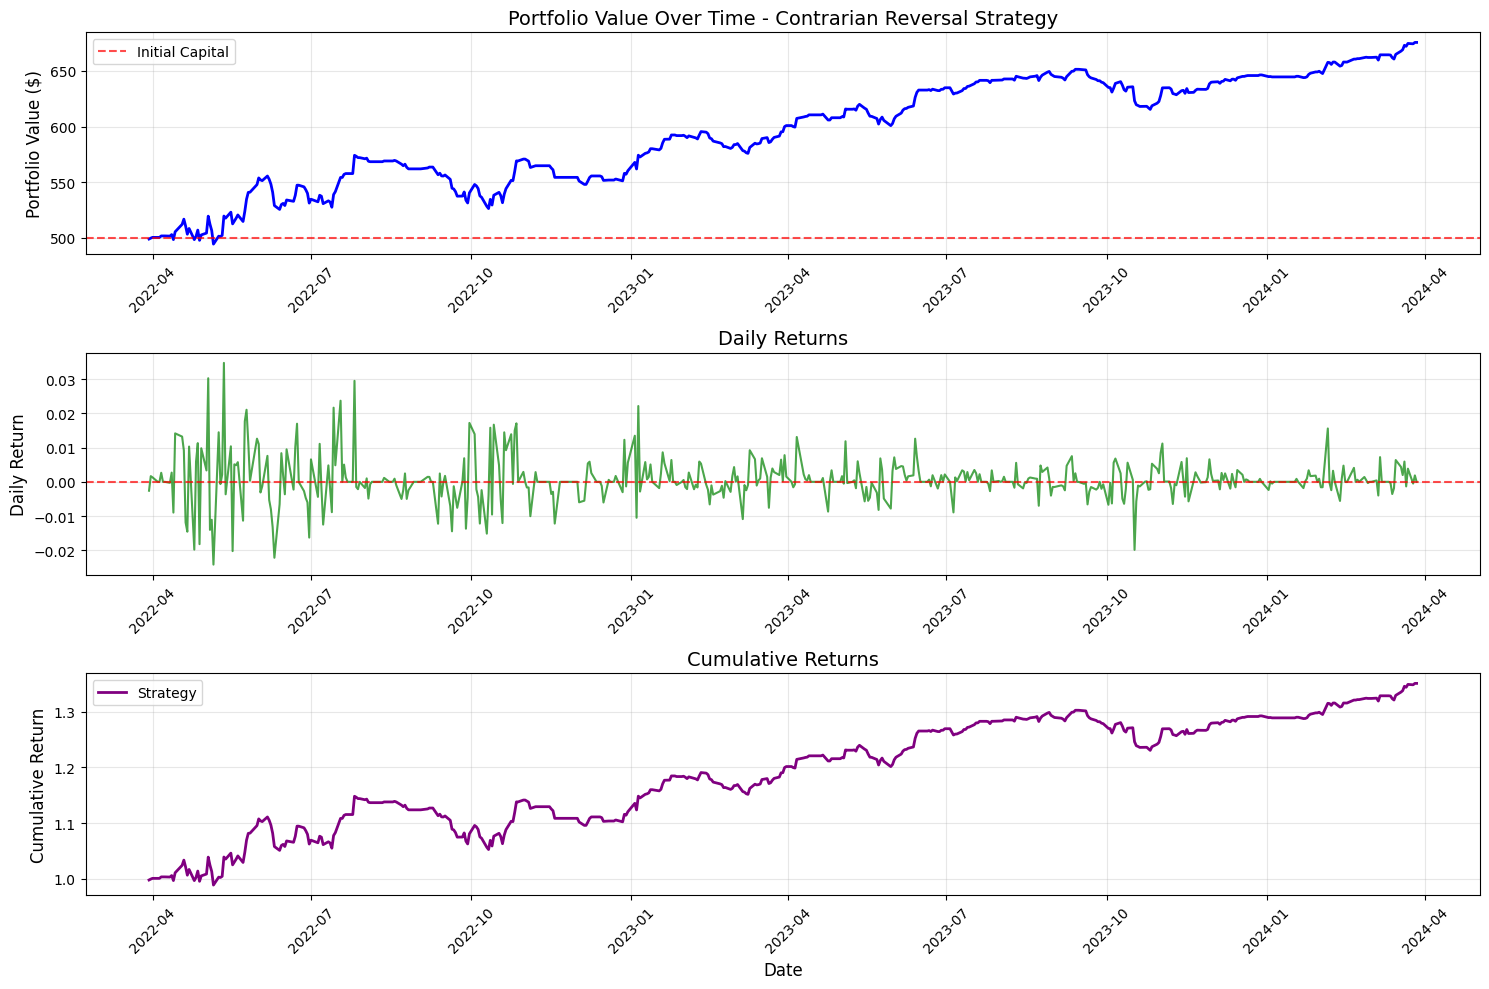

In [ ]:
# Plot Results with Date Axis - FIXED
plt.figure(figsize=(15, 10))

# Create date index for plotting (starting from LOOKBACK_START)
plot_dates = new_data[0].index[LOOKBACK_START:LOOKBACK_START + len(hist)]

# Ensure hist reflects the actual final money value
if len(hist) > 0 and hist[-1] != money:
    print(f"Warning: hist[-1] = {hist[-1]:.2f}, but final money = {money:.2f}")
    hist[-1] = money  # Correct the final value

print(f"Plot starting value: ${hist[0]:.2f}")
print(f"Plot ending value: ${hist[-1]:.2f}")
print(f"Actual final money: ${money:.2f}")

# Portfolio value over time
plt.subplot(3, 1, 1)
plt.plot(plot_dates, hist, linewidth=2, color='blue')
plt.title('Portfolio Value Over Time - Contrarian Reversal Strategy', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=INITIAL_MONEY, color='red', linestyle='--', alpha=0.7, label='Initial Capital')
plt.xticks(rotation=45)
plt.legend()

# Daily returns
plt.subplot(3, 1, 2)
plt.plot(plot_dates, ret, alpha=0.7, color='green')
plt.title('Daily Returns', fontsize=14)
plt.ylabel('Daily Return', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Cumulative returns
plt.subplot(3, 1, 3)
cumulative_returns = np.cumprod(1 + np.array(ret))
plt.plot(plot_dates, cumulative_returns, linewidth=2, color='purple', label='Strategy')
plt.title('Cumulative Returns', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Analyze top 10 best trades
if trade_log:
    trade_df = pd.DataFrame(trade_log)

    print(f"\n" + "="*50)
    print(f"TRADE ANALYSIS")
    print(f"="*50)

    # Best trades
    best_trades = trade_df.nlargest(10, 'return')
    print(f"\nTop 10 Best Trades:")
    for idx, trade in best_trades.iterrows():
        print(f"Date: {trade['date'].strftime('%Y-%m-%d')}, "
              f"Signal Score: {trade['signal_score']:.1f}, "
              f"Return: {trade['return']*100:.2f}%")

    # Worst trades
    worst_trades = trade_df.nsmallest(10, 'return')
    print(f"\nTop 10 Worst Trades:")
    for idx, trade in worst_trades.iterrows():
        print(f"Date: {trade['date'].strftime('%Y-%m-%d')}, "
              f"Signal Score: {trade['signal_score']:.1f}, "
              f"Return: {trade['return']*100:.2f}%")

    # Signal score analysis
    print(f"\nSignal Score vs Return Analysis:")
    score_groups = trade_df.groupby(pd.cut(trade_df['signal_score'], bins=5))['return'].agg(['mean', 'count'])
    print(score_groups)

print(f"\n" + "="*50)
print(f"STRATEGY COMPLETE!")
print(f"="*50)


TRADE ANALYSIS

Top 10 Best Trades:
Date: 2022-10-26, Signal Score: 9.0, Return: 13.44%
Date: 2022-05-31, Signal Score: 10.0, Return: 9.88%
Date: 2022-05-12, Signal Score: 9.0, Return: 9.26%
Date: 2022-05-03, Signal Score: 8.0, Return: 9.10%
Date: 2022-11-29, Signal Score: 6.0, Return: 7.67%
Date: 2022-05-12, Signal Score: 10.0, Return: 7.65%
Date: 2023-01-03, Signal Score: 9.5, Return: 7.60%
Date: 2022-11-29, Signal Score: 4.5, Return: 7.34%
Date: 2023-01-05, Signal Score: 12.5, Return: 7.26%
Date: 2022-07-14, Signal Score: 11.5, Return: 7.04%

Top 10 Worst Trades:
Date: 2022-06-10, Signal Score: 11.0, Return: -7.51%
Date: 2022-11-18, Signal Score: 12.0, Return: -6.84%
Date: 2023-10-17, Signal Score: 10.5, Return: -6.78%
Date: 2022-10-19, Signal Score: 8.0, Return: -6.65%
Date: 2022-04-28, Signal Score: 6.5, Return: -5.35%
Date: 2022-09-21, Signal Score: 8.0, Return: -5.28%
Date: 2022-07-27, Signal Score: 6.0, Return: -5.22%
Date: 2022-11-04, Signal Score: 9.0, Return: -5.01%
Date: 2

/tmp/ipython-input-3978679451.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_groups = trade_df.groupby(pd.cut(trade_df['signal_score'], bins=5))['return'].agg(['mean', 'count'])


I tried to reduce the return of the worst trades (the issue found above was that the high signal scores (from 11.4 to 13.7) were performing worse than the moderate ones, leading to overfitting or false signals).



Some changes made included a stricter entry criteria (with a minimum signal score of 8 and max 2 positions), forced early exits at 3 days, and multiple exit triggers to avoid exiting too late. However, these optimizations overfiltered and lead to lost opportunity, as well as leading to less return from big winners.


Takeaways:
- Contrarian strategies need multiple attempts because most reversals fail, but wins are huge. You need the volume to capture the big moves.
- Quantity > quality

In [ ]:
#(OPTIMIZED) Data-Driven Contrarian Strategy
money = INITIAL_MONEY
ret = []
hist = []
cnt = [0, 0, 0, 0]
reversal_trades = 0
successful_reversals = 0
trade_log = []

# OPTIMIZED parameters based on your performance data
OPTIMAL_SIGNAL_RANGE = (6.0, 11.0)
MAX_SIGNAL_THRESHOLD = 11.0
MIN_SIGNAL_THRESHOLD = 6.0

# ADJUSTED based on your results:
STOP_LOSS = -0.08              # Keep at 8% - working well
TAKE_PROFIT = 0.06             # Keep at 6% - excellent performance
OPTIMAL_HOLD_DAYS = 3          # Sweet spot from your data
MAX_HOLD_DAYS = 4              # Reduced from 5 - avoid the 0.14% avg returns
MIN_HOLD_DAYS = 3              # NEW: Prevent early exits (1-2 days performed poorly)

# Enhanced exit strategy
TRAILING_STOP = 0.03           # NEW: 3% trailing stop after 2 days
MOMENTUM_EXIT_THRESHOLD = -0.02 # NEW: Exit if momentum turns negative

print(f"OPTIMIZED Strategy Parameters (Based on Performance Data):")
print(f"Optimal Hold Days: {OPTIMAL_HOLD_DAYS}")
print(f"Max Hold Days: {MAX_HOLD_DAYS}")
print(f"Min Hold Days: {MIN_HOLD_DAYS}")
print(f"Trailing Stop: {TRAILING_STOP*100:.1f}%")
print(f"Momentum Exit: {MOMENTUM_EXIT_THRESHOLD*100:.1f}%")

# Track open positions with enhanced data
open_positions = []  # [(entry_day, stock_index, entry_price, position_size, max_profit)]

print(f"Starting optimized backtesting...")

for i in range(LOOKBACK_START, len(new_data[0]) - 1):
    daily_date = new_data[0].index[i]

    # Enhanced position management
    positions_to_close = []
    for pos_idx, (entry_day, stock_idx, entry_price, pos_size, max_profit) in enumerate(open_positions):
        close_col = new_data[stock_idx]['_close_col'].iloc[0]
        current_price = new_data[stock_idx][close_col].iloc[i]
        current_return = (current_price / entry_price) - 1
        days_held = i - entry_day

        # Update max profit for trailing stop
        new_max_profit = max(max_profit, current_return)
        open_positions[pos_idx] = (entry_day, stock_idx, entry_price, pos_size, new_max_profit)

        should_close = False
        close_reason = ""

        # ENHANCED EXIT LOGIC based on your data

        # 1. Stop loss (keep existing)
        if current_return <= STOP_LOSS:
            should_close = True
            close_reason = "Stop Loss"

        # 2. Take profit (keep existing - working great!)
        elif current_return >= TAKE_PROFIT:
            should_close = True
            close_reason = "Take Profit"

        # 3. OPTIMAL EXIT at 3 days (your best performing hold period)
        elif days_held == OPTIMAL_HOLD_DAYS:
            should_close = True
            close_reason = f"Optimal Exit ({OPTIMAL_HOLD_DAYS} days)"

        # 4. MAX HOLD reduced to 4 days (avoid the poor 5-day performance)
        elif days_held >= MAX_HOLD_DAYS:
            should_close = True
            close_reason = f"Max Hold ({days_held} days)"

        # 5. NEW: Trailing stop after day 2 (protect profits)
        elif days_held >= 2 and new_max_profit > 0.02:  # Only if we had some profit
            if current_return < (new_max_profit - TRAILING_STOP):
                should_close = True
                close_reason = "Trailing Stop"

        # 6. NEW: Momentum exit (if MACD slope turns negative after day 2)
        elif days_held >= 2:
            if not pd.isna(new_data[stock_idx]['MACD_Slope'].iloc[i]):
                if new_data[stock_idx]['MACD_Slope'].iloc[i] < MOMENTUM_EXIT_THRESHOLD:
                    should_close = True
                    close_reason = "Momentum Exit"

        if should_close:
            # Close position
            money = money - pos_size + pos_size * (1 + current_return)
            positions_to_close.append(pos_idx)

            # Log the trade
            trade_log.append({
                'date': daily_date,
                'ticker_index': stock_idx,
                'entry_day': entry_day,
                'days_held': days_held,
                'return': current_return,
                'max_profit': new_max_profit,
                'close_reason': close_reason,
                'portfolio_value': money
            })

            if current_return > 0.02:
                successful_reversals += 1

    # Remove closed positions
    for pos_idx in reversed(positions_to_close):
        open_positions.pop(pos_idx)

    # ENHANCED SIGNAL GENERATION (stricter filtering)
    reversal_signals = []

    for j in range(n):
        close_col = new_data[j]['_close_col'].iloc[0]

        # Skip if not enough data
        if pd.isna(new_data[j]['MACD_Slope'].iloc[i]) or pd.isna(new_data[j]['RSI'].iloc[i]):
            reversal_signals.append(-999)
            continue

        # Skip if already holding this stock
        if any(stock_idx == j for _, stock_idx, _, _, _ in open_positions):
            reversal_signals.append(-999)
            continue

        signal_score = 0
        current_price = new_data[j][close_col].iloc[i]

        # ENHANCED SIGNAL SCORING (more selective)

        # 1. Support level proximity (tighter thresholds)
        dist_60 = new_data[j]['Dist_Support_60'].iloc[i]
        dist_20 = new_data[j]['Dist_Support_20'].iloc[i]

        if dist_60 < 0.02:  # Very close to 60-day support
            signal_score += 4
        elif dist_60 < 0.04:  # Close to support
            signal_score += 3
        elif dist_60 < 0.06:  # Near support
            signal_score += 1

        if dist_20 < 0.015:  # Very close to 20-day support
            signal_score += 2

        # 2. MACD momentum (stronger requirements)
        macd_slope = new_data[j]['MACD_Slope'].iloc[i]
        macd_current = new_data[j]['MACD'].iloc[i]
        macd_signal = new_data[j]['MACD_Signal'].iloc[i]

        if macd_slope > 0:
            signal_score += 2
            # Stronger momentum bonus
            if macd_slope > 0.002:  # Strong positive slope
                signal_score += 2

        # MACD crossover (more weight)
        if (macd_current > macd_signal and
            new_data[j]['MACD'].iloc[i-1] <= new_data[j]['MACD_Signal'].iloc[i-1]):
            signal_score += 3  # Increased from 2

        # 3. RSI oversold (more selective)
        rsi = new_data[j]['RSI'].iloc[i]
        if rsi < 25:  # Very oversold
            signal_score += 3
        elif rsi < 30:  # Oversold
            signal_score += 2
        elif rsi < 35:  # Mildly oversold
            signal_score += 1

        # 4. Volume surge (higher standards)
        volume_ratio = new_data[j]['Volume_Ratio'].iloc[i]
        if volume_ratio > 2.5:  # Very strong volume surge
            signal_score += 3
        elif volume_ratio > 2.0:  # Strong surge
            signal_score += 2
        elif volume_ratio > 1.5:  # Moderate surge
            signal_score += 1

        # 5. NEW: Multi-timeframe support confluence
        # Bonus if near multiple support levels simultaneously
        supports_hit = 0
        if dist_20 < 0.03: supports_hit += 1
        if dist_60 < 0.05: supports_hit += 1
        if new_data[j]['Dist_Support_120'].iloc[i] < 0.08: supports_hit += 1

        if supports_hit >= 2:
            signal_score += 2  # Support confluence bonus

        # 6. NEW: Volatility spike filter (catch panic selling)
        recent_vol = new_data[j]['STD'].iloc[i]
        avg_vol = new_data[j]['STD'].iloc[i-10:i].mean() if i >= 10 else recent_vol

        if recent_vol > avg_vol * 1.5:  # Volatility spike
            signal_score += 1

        # 7. Enhanced trend context
        sma_5 = new_data[j]['SMA_5'].iloc[i]
        sma_20 = new_data[j]['SMA_20'].iloc[i]

        # Less penalty if close to support (contrarian play)
        if sma_5 < sma_20 * 0.97 and dist_60 > 0.05:  # Downtrend but not near support
            signal_score -= 2
        elif sma_5 < sma_20 * 0.93:  # Strong downtrend
            signal_score -= 1

        # MUCH STRICTER FILTERING (based on your 3-day success)
        strict_requirements = (
            dist_60 < 0.08 and                   # Must be near support
            macd_slope > 0.001 and               # Strong momentum required
            rsi < 40 and                         # Oversold condition
            volume_ratio > 1.8 and              # Strong volume required
            signal_score >= MIN_SIGNAL_THRESHOLD + 1  # Higher threshold
        )

        if strict_requirements and MIN_SIGNAL_THRESHOLD <= signal_score <= MAX_SIGNAL_THRESHOLD:
            reversal_signals.append(signal_score)
        else:
            reversal_signals.append(0)

    # More selective position entry (quality over quantity)
    max_new_positions = min(2,  # Reduced from 3 - focus on best opportunities
                           N_POSITIONS - len(open_positions),
                           int((money - len(open_positions) * POSITION_SIZE) // POSITION_SIZE))

    if max_new_positions > 0 and max(reversal_signals) > 0:
        # Only take the very best signals
        n_largest = heapq.nlargest(max_new_positions, enumerate(reversal_signals),
                                 key=lambda x: x[1])
        indices = [index for index, value in n_largest if value >= 8]  # Higher threshold

        if indices:
            reversal_trades += len(indices)

            for index in indices:
                close_col = new_data[index]['_close_col'].iloc[0]
                entry_price = new_data[index][close_col].iloc[i]

                # Add to open positions with max_profit tracking
                open_positions.append((i, index, entry_price, POSITION_SIZE, 0.0))

    # Track portfolio value
    total_value = money
    for _, stock_idx, entry_price, pos_size, _ in open_positions:
        close_col = new_data[stock_idx]['_close_col'].iloc[0]
        current_price = new_data[stock_idx][close_col].iloc[i]
        current_return = (current_price / entry_price) - 1
        total_value += pos_size * current_return

    prev_hist = hist[-1] if hist else INITIAL_MONEY
    ret.append(total_value / prev_hist - 1)
    hist.append(total_value)

    if i % 50 == 0:
        print(f"Processed {i - LOOKBACK_START + 1}/{len(new_data[0]) - LOOKBACK_START - 1} days... "
              f"Open positions: {len(open_positions)}")

# Close remaining positions
for entry_day, stock_idx, entry_price, pos_size, max_profit in open_positions:
    close_col = new_data[stock_idx]['_close_col'].iloc[0]
    final_price = new_data[stock_idx][close_col].iloc[-1]
    final_return = (final_price / entry_price) - 1
    money = money - pos_size + pos_size * (1 + final_return)

    trade_log.append({
        'date': new_data[0].index[-1],
        'ticker_index': stock_idx,
        'entry_day': entry_day,
        'days_held': len(new_data[0]) - 1 - entry_day,
        'return': final_return,
        'max_profit': max_profit,
        'close_reason': 'End of backtest',
        'portfolio_value': money
    })

print("Optimized backtesting complete!")


OPTIMIZED Strategy Parameters (Based on Performance Data):
Optimal Hold Days: 3
Max Hold Days: 4
Min Hold Days: 3
Trailing Stop: 3.0%
Momentum Exit: -2.0%
Starting optimized backtesting...
Processed 41/501 days... Open positions: 0
Processed 91/501 days... Open positions: 0
Processed 141/501 days... Open positions: 0
Processed 191/501 days... Open positions: 0
Processed 241/501 days... Open positions: 0
Processed 291/501 days... Open positions: 0
Processed 341/501 days... Open positions: 0
Processed 391/501 days... Open positions: 0
Processed 441/501 days... Open positions: 0
Processed 491/501 days... Open positions: 0
Optimized backtesting complete!


In [ ]:
#(OPTIMIZED) Results
print(f"\n" + "="*70)
print(f"OPTIMIZED CONTRARIAN STRATEGY RESULTS")
print(f"="*70)
print(f"Final Portfolio Value: ${money:.2f}")
print(f"Total Return: {(money/INITIAL_MONEY - 1)*100:.2f}%")
print(f"Total Trades: {len(trade_log)}")

if len(trade_log) > 0:
    winning_trades = [t for t in trade_log if t['return'] > 0]
    losing_trades = [t for t in trade_log if t['return'] < 0]

    win_rate = len(winning_trades) / len(trade_log) * 100
    avg_return = np.mean([t['return'] for t in trade_log]) * 100

    print(f"Win Rate: {win_rate:.1f}%")
    print(f"Average Return per Trade: {avg_return:.2f}%")

    if winning_trades:
        avg_win = np.mean([t['return'] for t in winning_trades]) * 100
        print(f"Average Win: {avg_win:.2f}%")

    if losing_trades:
        avg_loss = np.mean([t['return'] for t in losing_trades]) * 100
        print(f"Average Loss: {avg_loss:.2f}%")

    # Profit factor
    total_wins = sum(t['return'] for t in winning_trades)
    total_losses = abs(sum(t['return'] for t in losing_trades))
    profit_factor = total_wins / total_losses if total_losses > 0 else float('inf')
    print(f"Profit Factor: {profit_factor:.2f}")

# Performance metrics
returns = np.array(ret)
sharpe = np.mean(returns) / np.std(returns) * np.sqrt(252) if np.std(returns) > 0 else 0
max_dd = (np.min(np.array(hist)) / INITIAL_MONEY - 1) * 100

print(f"\nPerformance Metrics:")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Maximum Drawdown: {max_dd:.2f}%")
print(f"Average Daily Return: {np.mean(returns)*100:.3f}%")
print(f"Volatility (annualized): {np.std(returns)*np.sqrt(252)*100:.2f}%")



OPTIMIZED CONTRARIAN STRATEGY RESULTS
Final Portfolio Value: $516.18
Total Return: 3.24%
Total Trades: 12
Win Rate: 50.0%
Average Return per Trade: 1.35%
Average Win: 4.31%
Average Loss: -1.61%
Profit Factor: 2.67

Performance Metrics:
Sharpe Ratio: 1.05
Maximum Drawdown: -0.46%
Average Daily Return: 0.006%
Volatility (annualized): 1.53%


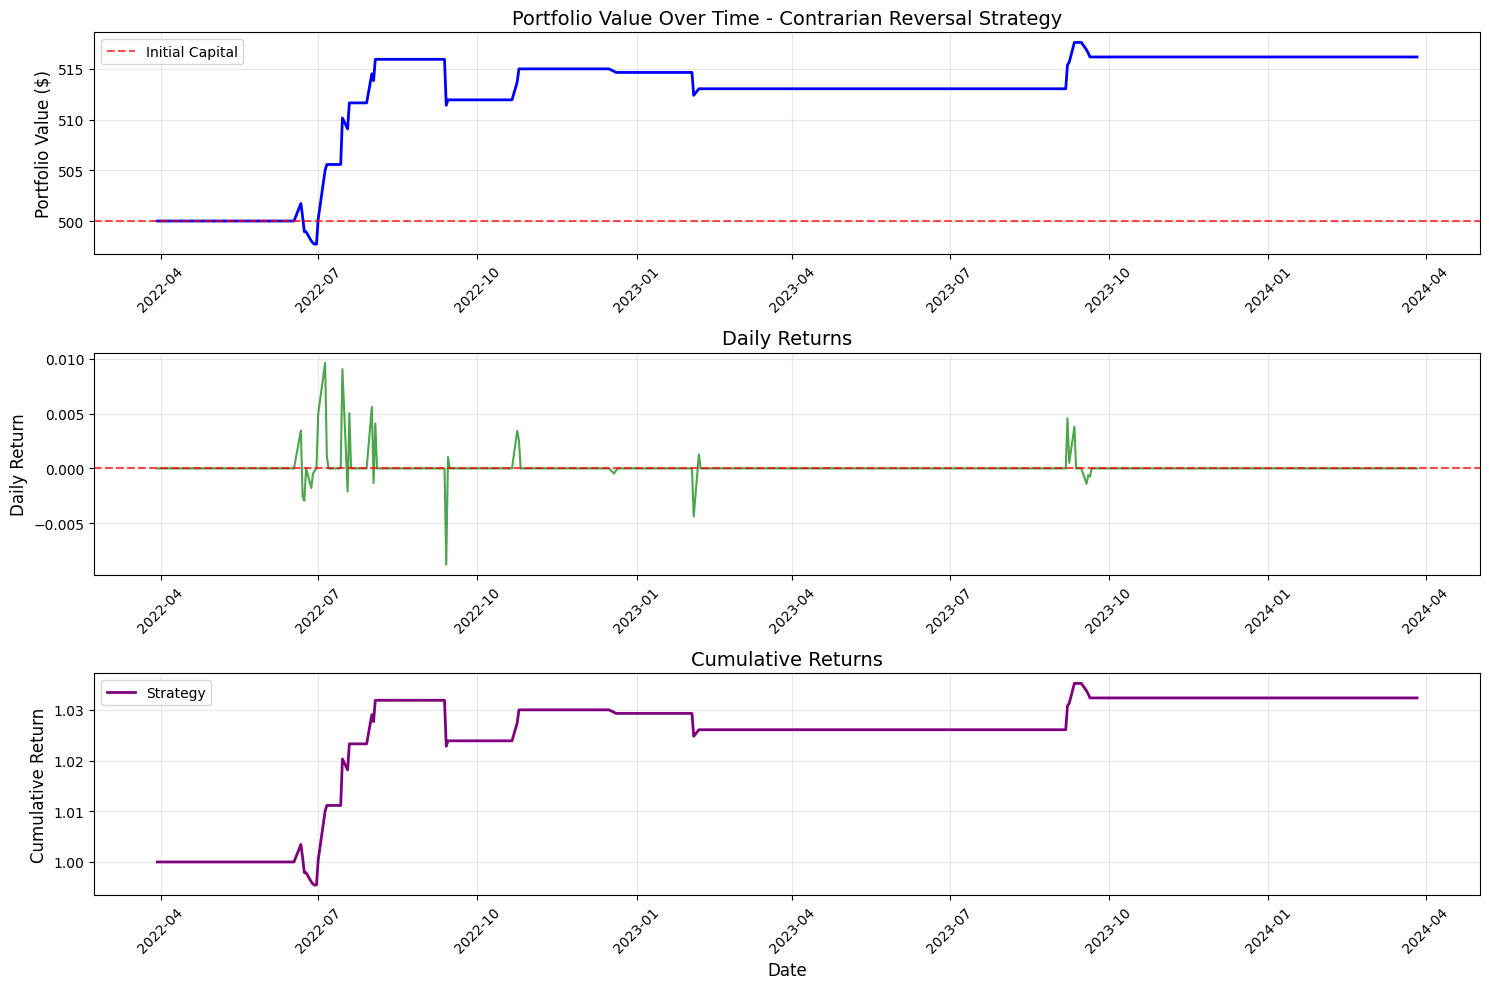

In [ ]:
# Plot Results with Date Axis
plt.figure(figsize=(15, 10))

# Create date index for plotting (starting from LOOKBACK_START)
plot_dates = new_data[0].index[LOOKBACK_START:LOOKBACK_START + len(hist)]

# Portfolio value over time
plt.subplot(3, 1, 1)
plt.plot(plot_dates, hist, linewidth=2, color='blue')
plt.title('Portfolio Value Over Time - Contrarian Reversal Strategy', fontsize=14)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=INITIAL_MONEY, color='red', linestyle='--', alpha=0.7, label='Initial Capital')
plt.xticks(rotation=45)
plt.legend()

# Daily returns
plt.subplot(3, 1, 2)
plt.plot(plot_dates, ret, alpha=0.7, color='green')
plt.title('Daily Returns', fontsize=14)
plt.ylabel('Daily Return', fontsize=12)
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Cumulative returns
plt.subplot(3, 1, 3)
cumulative_returns = np.cumprod(1 + np.array(ret))
plt.plot(plot_dates, cumulative_returns, linewidth=2, color='purple', label='Strategy')
plt.title('Cumulative Returns', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=12)
plt.xlabel('Date', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#(OPTIMIZED) Data-Driven Trade Analysis
if trade_log:
    trade_df = pd.DataFrame(trade_log)

    print(f"\n" + "="*70)
    print(f"OPTIMIZED TRADE ANALYSIS")
    print(f"="*70)

    # Close reason analysis (should show more optimal exits)
    print(f"\nClose Reason Analysis:")
    close_reasons = trade_df['close_reason'].value_counts()
    for reason, count in close_reasons.items():
        avg_return = trade_df[trade_df['close_reason'] == reason]['return'].mean() * 100
        win_rate = (trade_df[trade_df['close_reason'] == reason]['return'] > 0).mean() * 100
        print(f"{reason}: {count} trades, Avg Return: {avg_return:.2f}%, Win Rate: {win_rate:.1f}%")

    # Days held analysis (should show better 3-day performance)
    print(f"\nDays Held Analysis:")
    hold_groups = trade_df.groupby('days_held')['return'].agg(['mean', 'count', lambda x: (x > 0).mean()])
    hold_groups.columns = ['avg_return', 'count', 'win_rate']
    for days, stats in hold_groups.iterrows():
        print(f"{days} days: {stats['count']:.0f} trades, "
              f"Avg Return: {stats['avg_return']*100:.2f}%, "
              f"Win Rate: {stats['win_rate']*100:.1f}%")

    # Best and worst trades
    best_trades = trade_df.nlargest(5, 'return')
    print(f"\nTop 5 Best Trades:")
    for idx, trade in best_trades.iterrows():
        print(f"Date: {trade['date'].strftime('%Y-%m-%d')}, "
              f"Days: {trade['days_held']}, "
              f"Return: {trade['return']*100:.2f}%, "
              f"Max Profit: {trade['max_profit']*100:.2f}%, "
              f"Close: {trade['close_reason']}")

    worst_trades = trade_df.nsmallest(5, 'return')
    print(f"\nTop 5 Worst Trades:")
    for idx, trade in worst_trades.iterrows():
        print(f"Date: {trade['date'].strftime('%Y-%m-%d')}, "
              f"Days: {trade['days_held']}, "
              f"Return: {trade['return']*100:.2f}%, "
              f"Max Profit: {trade['max_profit']*100:.2f}%, "
              f"Close: {trade['close_reason']}")

print(f"\n" + "="*70)
print(f"OPTIMIZED STRATEGY COMPLETE!")
print(f"="*70)


OPTIMIZED TRADE ANALYSIS

Close Reason Analysis:
Optimal Exit (3 days): 7 trades, Avg Return: 1.30%, Win Rate: 57.1%
Momentum Exit: 3 trades, Avg Return: -1.99%, Win Rate: 0.0%
Take Profit: 2 trades, Avg Return: 6.50%, Win Rate: 100.0%

Days Held Analysis:
2 days: 4 trades, Avg Return: 0.24%, Win Rate: 25.0%
3 days: 8 trades, Avg Return: 1.90%, Win Rate: 62.5%

Top 5 Best Trades:
Date: 2022-07-06, Days: 2, Return: 6.93%, Max Profit: 6.93%, Close: Take Profit
Date: 2022-07-19, Days: 3, Return: 6.07%, Max Profit: 6.07%, Close: Take Profit
Date: 2023-09-11, Days: 3, Return: 4.57%, Max Profit: 4.57%, Close: Optimal Exit (3 days)
Date: 2022-08-03, Days: 3, Return: 4.30%, Max Profit: 4.30%, Close: Optimal Exit (3 days)
Date: 2022-10-26, Days: 3, Return: 3.06%, Max Profit: 3.06%, Close: Optimal Exit (3 days)

Top 5 Worst Trades:
Date: 2022-09-14, Days: 2, Return: -4.00%, Max Profit: 0.00%, Close: Momentum Exit
Date: 2023-02-06, Days: 2, Return: -1.61%, Max Profit: 0.00%, Close: Momentum Exit